<h1><center>Laboratory Work 9.</center></h1>
<h2><center>
    Predicting article views on Wiki using $prophet$ 
    <div>(Прогнозування переглядів статті на Wiki з використанням $prophet$)</div>
</center></h2>

<a class="anchor" id="9"></a>

## Outline

- [9.1. Data Preprocessing and Rolling Window Analysis](#lab-9.1)
- [9.2. Exponential Smoothing and Holt-Winters Models](#lab-9.2)
- [9.3. Stationarity, SARIMA, and Econometric Approaches](#lab-9.3)
- [9.4. Feature Engineering and Linear Models for Time Series](#lab-9.4)
- [9.5. Advanced Forecasting with Prophet](#lab-9.5)

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)
init_notebook_mode(connected=True)

5.9.0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

from prophet import Prophet

plt.rcParams["figure.figsize"] = (15, 10)

In [3]:
def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

## Data preparation

In [4]:
credit_scoring_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/refs/heads/main/02_assignments/ida_lab-09_prophet/wiki_machine_learning.csv'

df = pd.read_csv(credit_scoring_url, sep =',')
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
0,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
1,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
2,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
3,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
4,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [5]:
df.shape

(383, 7)

## Predicting with Prophet
We will train at first 5 months and predict the number of trips for June.

In [6]:
df.date = pd.to_datetime(df.date)

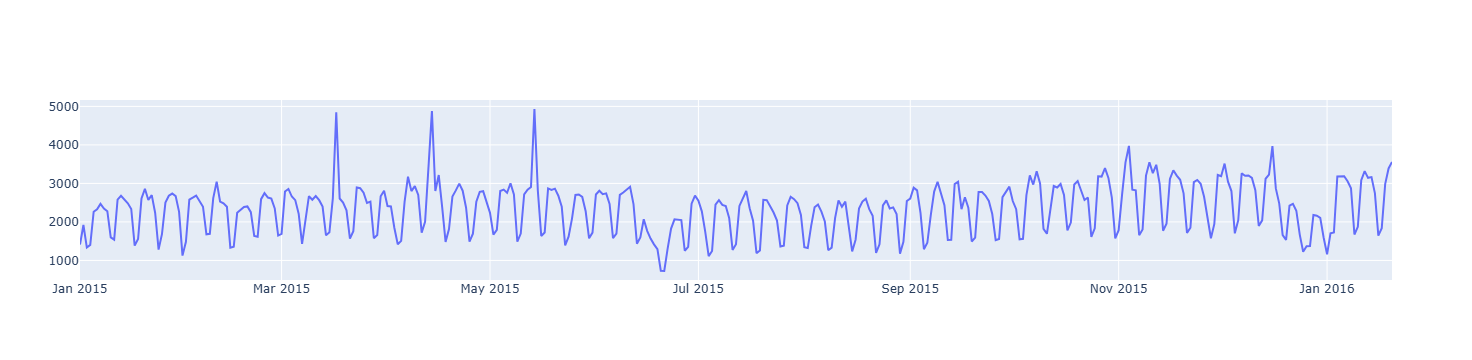

In [7]:
plotly_df(df.set_index("date")[["count"]])

Before working with [`prophet`](https://pypi.org/project/prophet/#history), install it via following command in your terminal:
```python
pip install fbprophet
```

In [8]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
df.tail()

,ds,y
379,2016-01-16,1644
380,2016-01-17,1836
381,2016-01-18,2983
382,2016-01-19,3389
383,2016-01-20,3559


<a class="anchor" id="lab-9.1"></a>

## <span style="color:blue; font-size:1.2em;">9.1. Data Preprocessing and Rolling Window Analysis</span>

[Back to the outline](#lab-9)

### <span style="color:red; font-size:1.5em;">Task 1</span>

---
**Variant 1:**  
Use **wiki_machine_learning.csv** to explore daily page views for the “Machine_learning” article. First, remove rows with missing or zero ‘count’ values to ensure data consistency. Then resample the data into weekly intervals and apply a 4-week rolling mean to observe smoothed trends. Investigate whether there are obvious seasonal patterns in the time series after applying the rolling window.

*Technical note:*  
Rely on `pandas` to remove rows where ‘count’ is zero or NaN, use `resample('W')` for weekly aggregation, and apply `rolling(window=4).mean()`. Plot results with `matplotlib` to highlight seasonal variations.

---
**Variant 2:**  
Take the daily page views from **wiki_machine_learning.csv** and implement a rolling median with a 7-day window. This approach helps suppress extreme spikes in page views due to short-term bursts of popularity (e.g., news coverage of AI breakthroughs). Compare the rolling median plot to a standard rolling mean plot, explaining any differences in their ability to smooth the data.

*Technical note:*  
Use `df['rolling_median'] = df['count'].rolling(window=7).median()` and `df['rolling_mean'] = df['count'].rolling(window=7).mean()`. Plot both series side by side to visualize how medians vs. means handle outliers.

---
**Variant 3:**  
Convert the daily “Machine_learning” page views in **wiki_machine_learning.csv** to monthly frequency, handling missing or irregular entries by linear interpolation. Then apply a rolling standard deviation over a 2-month window to detect periods of high volatility in page views. Discuss whether these volatility spikes align with events such as new AI product launches or academic conferences.

*Technical note:*  
Use `pandas.resample('M').sum()` or `mean()`, then `interpolate(method='linear')`. Apply `rolling(window=2).std()` to the monthly series. Investigate peaks and link them to real or hypothesized AI-related events.

---
**Variant 4:**  
Perform a rolling window correlation between daily “Machine_learning” (**wiki_machine_learning.csv**) page views (the ‘count’ column) and a synthetic bounce rate metric you generate (e.g., random values from 0.0–1.0 to simulate user behavior). Use a 14-day rolling window to see if there is a shifting correlation pattern. Reflect on whether higher article views might relate to a higher or lower bounce rate.

*Technical note:*  
After creating a synthetic bounce rate column, apply `df['count'].rolling(window=14).corr(df['bounce_rate'])`. Plot the correlation values against time to observe changing relationships.

---
**Variant 5:**  
Focus on a 6-month subset of **wiki_machine_learning.csv** and remove days with extremely low ‘count’ to discard potential data entry mistakes. Then compute a 3-week rolling sum of page views to approximate cumulative interest in machine learning. Reflect on how this rolling sum can reveal persistent periods of elevated user engagement.

*Technical note:*  
Filter out low page-view days (`df = df[df['count'] > threshold]`). Use `rolling(window=3, min_periods=1).sum()` on weekly resampled data. Plot the aggregated page views over time.

---
**Variant 6:**  
Create a new time series from the daily “Machine_learning” (**wiki_machine_learning.csv**) page views aggregated into weekend vs. weekday groups. Then apply different rolling windows (e.g., 2-week vs. 8-week) to each subset to examine short-term vs. longer-term engagement patterns. Compare which window size better highlights holiday-driven spikes or longer industry trends.

*Technical note:*  
Use the `pandas` `.dt.weekday` property to label weekends vs. weekdays. Aggregate sums or means separately, then `rolling(window=2)` and `rolling(window=8)` to see how different smoothing intervals capture fluctuations.

---
**Variant 7:**  
Implement an exponentially weighted moving average (EWMA) for the daily “Machine_learning” (**wiki_machine_learning.csv**) page views using a 7-day span. Compare the EWMA results to a simple 7-day rolling mean, evaluating which approach more promptly responds to sudden surges in page views triggered by breaking news or scientific advancements.

*Technical note:*  
Use `df['ewm'] = df['count'].ewm(span=7, adjust=False).mean()` in `pandas`. Plot the EWMA side by side with the rolling mean (`df['count'].rolling(window=7).mean()`) to highlight responsiveness differences.

---
**Variant 8:**  
Fill missing daily page-view entries (if any) in **wiki_machine_learning.csv** with forward fill, then calculate a rolling standard deviation with a 10-day window. The goal is to identify stretches of days where view counts fluctuate widely, possibly reflecting external events like major AI conferences or media announcements.

*Technical note:*  
Use `df['count'].fillna(method='ffill', inplace=True)` for missing data. Then `df['roll_std'] = df['count'].rolling(10).std()`. Visualize changes in the standard deviation to spot volatility.

---
**Variant 9:**  
Filter out all entries where the date falls on weekends, analyzing only weekday “Machine_learning” (**wiki_machine_learning.csv**) page views. Next, use a 5-day rolling window on this subset to identify short-term patterns. Hypothesize how knowledge of typical weekday usage might be used by content creators or educators aiming to optimize exposure.

*Technical note:*  
Leverage `df[df['ds'].dt.weekday < 5]` to retain weekdays. Then apply `rolling(window=5).mean()` or `.sum()` and plot the results. Explore how ignoring weekends reveals distinct usage patterns.

---
**Variant 10:**  
Assess how the 7-day rolling median of daily page views has shifted over the course of an entire year in **wiki_machine_learning.csv**. By focusing on the median instead of the mean, you can reduce the influence of high-traffic anomalies caused by viral content. Note if certain months consistently show higher medians than others.

*Technical note:*  
Use `rolling(window=7).median()` for the daily ‘count’ and group by month or quarter (via `df['ds'].dt.month`) to compare typical usage patterns across the calendar year.

---
**Variant 11:**  
Experiment with multiple rolling window sizes (3 days, 7 days, 14 days) on the daily page views from **wiki_machine_learning.csv** to see how each smoothing level captures short-, medium-, and slightly longer-term fluctuations. Visualize and discuss which window size seems most appropriate for revealing cyclical trends, such as weekend peaks or monthly patterns.

*Technical note:*  
Generate separate columns for each rolling mean: `df['roll_3']`, `df['roll_7']`, `df['roll_14']`. Plot them together to compare smoothing extents.

---
**Variant 12:**  
Calculate rolling minimum and maximum page views over 7-day windows to gauge the range of daily attention “Machine_learning” (**wiki_machine_learning.csv**) receives within each week. Investigate whether the difference between the rolling minimum and maximum reveals repeated weekly spikes or a more constant level of interest.

*Technical note:*  
Use `df['roll_min'] = df['count'].rolling(7).min()` and `df['roll_max'] = df['count'].rolling(7).max()`. Subtract one from the other to get range values, and examine how they evolve.

---
**Variant 13:**  
Apply a 14-day rolling variance to the daily page views from **wiki_machine_learning.csv**. Look for periods with exceptionally high variance, which might correspond to online events (e.g., a viral ML breakthrough) causing view counts to fluctuate rapidly. Discuss how rolling variance helps in spotting these volatile intervals.

*Technical note:*  
`df['roll_var'] = df['count'].rolling(14).var()`. Combine the raw ‘count’ plot with the variance plot to detect relationships between usage spikes and statistical variability.

---
**Variant 14:**  
Insert zero values for any missing days in **wiki_machine_learning.csv**, then compute a 3-day rolling sum. This technique can help approximate short bursts of cumulative interest in machine learning, especially if certain days are underreported. Evaluate how adding zeros vs. other imputation strategies impacts the final rolling sum curve.

*Technical note:*  
Use `df.set_index('ds').asfreq('D', fill_value=0)` to ensure daily frequency, then `rolling(window=3).sum()`. Plot side by side with a non-zero-filled approach to compare.

---
**Variant 15:**  
Group the daily page views in **wiki_machine_learning.csv** by month and compute rolling statistics within each month separately (e.g., a rolling 5-day window). This reveals intra-month fluctuations. Analyze whether the start or end of certain months consistently shows higher activity, potentially correlating with academic or industry cycles.

*Technical note:*  
Use a grouped rolling approach, e.g. `df.groupby(df['ds'].dt.month)['count'].rolling(5).mean()`. Visualize the results to see monthly internal patterns.

---
**Variant 16:**  
Create rolling windows of 7 days and 28 days to compare short-term vs. monthly cycles in “Machine_learning” (**wiki_machine_learning.csv**) page views. Overlay the two smoothed series on the same plot to highlight their divergence. Discuss how smaller windows can catch sudden short-lived spikes, whereas larger windows reveal broader cyclical trends.

*Technical note:*  
Use `df['roll_7'] = ...rolling(7).mean()` and `df['roll_28'] = ...rolling(28).mean()`. Plot them together for direct comparison.

---
**Variant 17:**  
Exclude dates in **wiki_machine_learning.csv** that have page views above a certain threshold, presuming those may be data errors or anomalies. Then apply a 7-day rolling median to the cleaned dataset. Assess whether removing these outliers clarifies the underlying usage patterns, especially around typical weekdays vs. weekends.

*Technical note:*  
Choose a threshold (e.g., 3 standard deviations above the mean). Filter out the rows, then `rolling(7).median()`. Compare before/after outlier removal visually.

---
**Variant 18:**  
Focus on a rolling average with a 4-week window for “Machine_learning” (**wiki_machine_learning.csv**) page views, then annotate specific known AI-related events (like major conference dates) on the plot. Note how the rolling average changes after each event, and suggest whether the event might have driven sustained interest or just a temporary spike.

*Technical note:*  
Compute `rolling(window=4).mean()` on weekly resampled data. Use `matplotlib` or `plotly` to add vertical lines or markers for event dates.

---
**Variant 19:**  
Normalize the daily page views in **wiki_machine_learning.csv** by subtracting the mean and dividing by the standard deviation. Then apply a rolling mean with a 7-day window on the normalized series to observe times when interest is notably higher or lower than usual. Evaluate how normalization aids in identifying relative peaks.

*Technical note:*  
Standardize with `(df['count'] - df['count'].mean()) / df['count'].std()`. Then `rolling(7).mean()`. Plot to highlight standardized fluctuations, removing absolute scale differences.

---
**Variant 20:**  
Replace any missing data points in **wiki_machine_learning.csv** with a 3-day rolling median and then compute a 7-day rolling sum of page views. By combining this imputation method with a rolling sum, you can approximate cumulative engagement while minimizing the effect of single-day anomalies.

*Technical note:*  
Use `df['count'] = df['count'].fillna(df['count'].rolling(3).median())`. Then `df['rolling_sum'] = df['count'].rolling(7).sum()`. Plot to visualize the result of these combined techniques.

---

<a class="anchor" id="lab-9.2"></a>

## <span style="color:blue; font-size:1.2em;">9.2. Exponential Smoothing and Holt-Winters Models</span>

[Back to the outline](#lab-9)

### <span style="color:red; font-size:1.5em;">Task 2</span>

---
**Variant 1:**  
Apply simple exponential smoothing to the daily page views in **wiki_machine_learning.csv**, treating each day as an individual time step. Choose different smoothing levels ($\alpha$), such as 0.2 and 0.7, to see how quickly the model reacts to sudden spikes. Compare the smoothed series to see which value of $\alpha$ might be best for identifying short-term interest trends.

*Technical note:*  
Use `statsmodels.tsa.holtwinters.SimpleExpSmoothing(df['count'])` and vary `smoothing_level`. Plot both results and compare smoothing responsiveness.

---
**Variant 2:**  
Aggregate the daily “Machine_learning” (**wiki_machine_learning.csv**) page views into weekly totals and apply a Holt-Winters model with additive seasonality. Assume a weekly seasonal period of 7 to capture day-of-week variations. Evaluate how well the model handles any upward or downward trend in page views and note if weekend surges are detected.

*Technical note:*  
Use `ExponentialSmoothing(weekly_data, trend='add', seasonal='add', seasonal_periods=7)`. Compare MAPE or RMSE on a validation portion of the data.

---
**Variant 3:**  
Resample **wiki_machine_learning.csv** into monthly data and experiment with a multiplicative Holt-Winters model. This model is suitable if monthly page views exhibit a growing amplitude of fluctuations over time. Visualize the level, trend, and seasonal components to see if the multiplicative assumption aligns with real usage patterns.

*Technical note:*  
`ExponentialSmoothing(monthly_data, trend='add', seasonal='mul', seasonal_periods=12).fit()`. Review the `fittedvalues` and `.season` components for interpretation.

---
**Variant 4:**  
Using **wiki_machine_learning.csv**, convert the daily page views to weekly sums and split into training (first several months) and testing (remaining period). Fit Holt’s linear trend model, then forecast the next 6 weeks. Compare these forecasts with a naive approach (last observed value carried forward) to see which method better anticipates changes in page views.

*Technical note:*  
Use `ExponentialSmoothing(..., trend='add', seasonal=None)` from `statsmodels`. Evaluate forecasts via MSE or MAE on the test set, and plot to show forecast vs. actual.

---
**Variant 5:**  
Attempt to model day-of-week effects in “Machine_learning” (**wiki_machine_learning.csv**) page views using Holt’s method by first grouping the data into separate daily series or by employing advanced seasonal settings in an additive Holt-Winters model. Investigate whether ignoring day-of-week seasonality leads to systematic forecast error on weekends vs. weekdays.

*Technical note:*  
For a single Holt approach, decompose day-of-week patterns manually or use `ExponentialSmoothing` with `seasonal_periods=7`. Compare results in terms of MAPE or bias on weekends vs. weekdays.

---
**Variant 6:**  
Take the daily view counts from **wiki_machine_learning.csv**, assuming a repeating 7-day cycle. Fit a Holt-Winters model with additive seasonality of period 7. Evaluate how effectively it captures typical weekly fluctuations, such as potential Monday spikes or Saturday dips, and interpret any residual patterns.

*Technical note:*  
`ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=7).fit()`. Examine the fitted seasonal values to see which days of the week produce higher or lower page views.

---
**Variant 7:**  
Using **wiki_machine_learning.csv**, compare three smoothing approaches on the aggregated monthly page views: (1) Simple Exponential Smoothing, (2) Holt’s linear trend, and (3) Holt-Winters with multiplicative seasonality. Identify which method best describes long-term growth or cyclical patterns. Summarize results using standard error metrics or a hold-out test.

*Technical note:*  
Use `SimpleExpSmoothing`, `Holt`, and `ExponentialSmoothing(..., seasonal='mul', seasonal_periods=12)`. Evaluate each model’s performance using AIC or MAPE, then plot to visualize differences.

---
**Variant 8:**  
Investigate if damping the trend in a Holt model helps avoid over-forecasting for “Machine_learning” (**wiki_machine_learning.csv**) article views. You might suspect that the page cannot keep growing indefinitely at the same rate. Compare a model with `damped_trend=True` to one without damping, and see which more realistically projects the next few weeks.

*Technical note:*  
Set `ExponentialSmoothing(..., trend='add', damped_trend=True)`. Evaluate damping parameters that reduce the slope over time. Compare predictions with those from a non-damped model.

---
**Variant 9:**  
Focus on weekly totals from **wiki_machine_learning.csv** over a year. Apply an additive Holt-Winters model if you expect a mostly linear upward trend or a stable weekly seasonality. Explore whether the model’s predictions align with known events (like the start of an academic semester), judging if holiday or semester breaks disrupt usage trends.

*Technical note:*  
`ExponentialSmoothing(weekly_data, trend='add', seasonal='add', seasonal_periods=52)` might approximate a year of weekly data. Adjust `seasonal_periods` if the data covers less than a year.

---
**Variant 10:**  
Split the daily “Machine_learning” (**wiki_machine_learning.csv**) page views into training (first few months) and testing (last month). Fit a Holt-Winters model with a 7-day seasonality to the training period. Then forecast into the test period and compare predicted daily page views with actual counts. Evaluate the forecast accuracy using RMSE or MAE.

*Technical note:*  
Create training and testing sets with `df.iloc[:train_end]` and `df.iloc[train_end:]`. Fit with `ExponentialSmoothing(..., seasonal_periods=7)`. Use `sklearn.metrics.mean_absolute_error` or `mean_squared_error`.

---
**Variant 11:**  
Implement simple exponential smoothing on the daily “Machine_learning” (**wiki_machine_learning.csv**) page views, with a low alpha (e.g., 0.1) and a higher alpha (e.g., 0.9). Explain how the choice of alpha influences how recent data points weigh on the forecast. Visualize the resulting smoothed lines and comment on the responsiveness to large traffic surges.

*Technical note:*  
Use `SimpleExpSmoothing(df['count']).fit(smoothing_level=...)`. Plot the results, focusing on how the higher alpha reacts immediately to spikes compared to the lower alpha.

---
**Variant 12:**  
Work with monthly aggregated page views from **wiki_machine_learning.csv**. Apply Holt’s linear model and then incorporate a damping parameter. Argue whether the damped forecast is more realistic if the page view trend has started leveling off, for instance, if mainstream interest in machine learning plateaus after an initial hype.

*Technical note:*  
`ExponentialSmoothing(monthly_data, trend='add', damped_trend=True, seasonal=None).fit()`. Compare the forecast lines for damped vs. non-damped over a multi-month horizon.

---
**Variant 13:**  
Emplying **wiki_machine_learning.csv**, test a multiplicative Holt-Winters model on monthly page views, hypothesizing that as the general interest in machine learning grows, the magnitude of seasonal fluctuations also expands proportionally. Verify if the residual plots confirm that a multiplicative trend/seasonality outperforms an additive model in capturing these amplitude variations.

*Technical note:*  
`ExponentialSmoothing(..., trend='mul', seasonal='mul', seasonal_periods=12).fit()`. Inspect residual distribution or use `statsmodels.graphics.tsaplots.plot_acf` to check for leftover patterns.

---
**Variant 14:**  
Use daily data and apply simple exponential smoothing to forecast the next 14 days of “Machine_learning” (**wiki_machine_learning.csv**) article views. Investigate whether the model is sensitive enough to capture short, news-driven spikes. Contrast these forecasts with a 7-day rolling average as a simpler baseline. Discuss how each method might be used in practice.

*Technical note:*  
`SimpleExpSmoothing` for short-term forecasting vs. `df['count'].rolling(7).mean()` as a naive approach. Plot them together with the actual data to measure differences.

---
**Variant 15:**  
Assume a weekly cycle in daily “Machine_learning” (**wiki_machine_learning.csv**) page views and apply a Holt-Winters model with a seasonal period of 7 for one full year of data. Check if the model effectively captures repeated weekly patterns, such as Monday and Tuesday surges. Assess how well it generalizes to new weeks by measuring forecast accuracy over a final hold-out month.

*Technical note:*  
Use `ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=7).fit()`. Evaluate the last month with MAPE or RMSE, comparing predicted vs. actual counts.

---
**Variant 16:**  
Work with the daily page-view series in **wiki_machine_learning.csv** for a 4-month window. Apply Holt’s method with a damped trend, expecting that interest in the page cannot accelerate endlessly. Discuss how adjusting the damping parameter to approach 1 might mimic a non-damped forecast, while lower values slow the growth rate faster.

*Technical note:*  
`Holt(df['count'], damped_trend=True).fit(optimised=True, damping_slope=...).forecast(...)`. Evaluate how different damping_slope values change forecasts.

---
**Variant 17:**  
Suppose monthly page views for the “Machine_learning” (**wiki_machine_learning.csv**) article peak every January when courses start. Fit a Holt-Winters model with a seasonal period of 12 on monthly data. Observe whether the additive seasonal component clearly reveals a January spike. Explain how adjusting `seasonal_periods` can accommodate alternate cycles if needed (e.g., quarterly or monthly offset).

*Technical note:*  
`ExponentialSmoothing(monthly_data, trend='add', seasonal='add', seasonal_periods=12).fit()`. Examine the seasonal component array to confirm a January effect.

---
**Variant 18:**  
Take weekly page views from **wiki_machine_learning.csv** for a 16-week period. Compare additive vs. multiplicative seasonality in a Holt-Winters forecast. If page views are gradually rising, a multiplicative model may show the weekend effect growing over time. Confirm whether the residual analysis supports one approach over the other.

*Technical note:*  
`ExponentialSmoothing(weekly_data, trend='add', seasonal='add' or 'mul', seasonal_periods=7 or 8).fit()`. Plot forecasts and residuals for both variants.

---
**Variant 19:**  
Identify months in **wiki_machine_learning.csv** that show spikes near the end (e.g., around final exam times). Fit a Holt-Winters model to the monthly-aggregated data. Compare the fitted seasonal pattern to the actual usage pattern at month-end. If mismatches occur, adjust parameters or consider a more complex approach (e.g., day-level seasonality).

*Technical note:*  
`ExponentialSmoothing(monthly_data, trend='add', seasonal='add', seasonal_periods=12).fit()`. Inspect the model’s seasonal factor near each month-end to see if it matches real spikes.

---
**Variant 20:**  
Use a simple exponential smoothing approach on the daily page views to generate short-term forecasts on the **wiki_machine_learning.csv** dataset, then incorporate an external variable (e.g., a binary indicator for weekends) by switching to a more advanced model like SARIMAX or a regression-based approach. Compare whether the external variable integration outperforms the simpler exponential smoothing method alone.

*Technical note:*  
Start with `SimpleExpSmoothing(df['count']).fit()`. Then consider a SARIMAX with exogenous weekend dummy. Compare forecast error in a hold-out period.

---

<a class="anchor" id="lab-9.3"></a>

## <span style="color:blue; font-size:1.2em;">9.3. Stationarity, SARIMA, and Econometric Approaches</span>

[Back to the outline](#lab-9)

### <span style="color:red; font-size:1.5em;">Task 3</span>

---
**Variant 1:**  
Perform an Augmented Dickey-Fuller (ADF) test on the daily “Machine_learning” page-view series from **wiki_machine_learning.csv** to check for stationarity. If results indicate non-stationarity (p-value > 0.05), apply first-order differencing. Plot the original series and the differenced series side by side to see how differencing affects the observed trend.

*Technical note:*  
Use `statsmodels.tsa.stattools.adfuller(df['count'])`. If needed, `df['diff'] = df['count'].diff()`. Compare results visually and with ADF again.

---
**Variant 2:**  
Assess both trend and weekly seasonality in the daily “Machine_learning” (**wiki_machine_learning.csv**) data. If the ADF test suggests non-stationarity, apply a seasonal differencing with period 7 (i.e., `df['count'].diff(7)`) to address weekly effects. Then re-run the ADF test to check if the differenced series is now stationary. Examine whether the log transform further stabilizes variance.

*Technical note:*  
Use `df['seasonal_diff'] = df['count'].diff(7)`. Optionally apply `np.log1p()` to reduce amplitude differences. Compare ADF p-values pre- and post-transform.

---
**Variant 3:**  
Fit a SARIMA model to the daily “Machine_learning” (**wiki_machine_learning.csv**) page views, aiming to capture both non-seasonal and weekly seasonal components. Use a grid search or `pmdarima.arima.auto_arima` to find an optimal (p,d,q) x (P,D,Q,7). Compare the final model’s AIC or MAPE to confirm you have an improved forecast over simpler ARIMA or naive models.

*Technical note:*  
`auto_arima(df['count'], seasonal=True, m=7)`. Alternatively, manually test SARIMA parameters in `statsmodels.tsa.statespace.SARIMAX`. Choose the best by AIC or BIC.

---
**Variant 4:**  
Investigate the presence of a polynomial trend in monthly aggregated “Machine_learning” (**wiki_machine_learning.csv**) page views. If you suspect a quadratic trend, remove it via polynomial regression or second-order differencing. Then fit an ARIMA model on the detrended data. Compare forecast accuracy in capturing cyclical usage after removing the polynomial trend component.

*Technical note:*  
Use polynomial detrending with `np.polyfit()` or second differencing (`df['count'].diff(2)`) if the pattern is quadratic. Then `ARIMA(order=(p,d,q))`. Evaluate improvements in forecast error.

---
**Variant 5:**  
Check for weekly seasonality in the daily page views from **wiki_machine_learning.csv**. If an ADF test indicates non-stationarity, apply ARIMA vs. SARIMA with weekly seasonal terms (m=7). Show how ignoring day-of-week patterns in a simple ARIMA model might lead to consistent under- or over-prediction on weekends.

*Technical note:*  
Use `SARIMAX(df['count'], order=(p,d,q), seasonal_order=(P,D,Q,7))`. Compare the residual patterns from ARIMA vs. SARIMA for day-of-week correlation.

---
**Variant 6:**  
If many days in **wiki_machine_learning.csv** have low or zero page views (hypothetically), a log transform might fail. Instead, consider differencing or partial usage of a Box-Cox transform with an offset. Evaluate stationarity via the ADF test. If achieved, fit an ARIMA model and discuss how near-zero counts complicate standard transformations.

*Technical note:*  
Detect zero counts, shift data by a small constant, e.g., `df['count']+1`, for Box-Cox transforms. Re-check stationarity before applying `ARIMA(...)`. Inspect residual distribution.

---
**Variant 7:**  
Apply both the ADF and KPSS tests to monthly aggregated “Machine_learning” (**wiki_machine_learning.csv**) page views to confirm stationarity or detect potential unit roots. If the results conflict (ADF might show stationarity while KPSS does not), try differencing or verifying the presence of seasonal trends. Then fit a SARIMA model with a seasonal period of 12 if monthly seasonality exists.

*Technical note:*  
`statsmodels.tsa.stattools.adfuller()` and `statsmodels.tsa.stattools.kpss()` for checking stationarity. Use `(P,D,Q,12)` if monthly cycles are identified.

---
**Variant 8:**  
Group daily “Machine_learning” (**wiki_machine_learning.csv**) page views by week, generating weekly sums, and check stationarity. If the series remains non-stationary, adopt SARIMA with `seasonal_order=(P,D,Q,52)` for potential yearly cycles (assuming you have at least a year of data). Compare the forecast performance vs. a simpler non-seasonal ARIMA to see if annual patterns matter.

*Technical note:*  
`df.resample('W').sum()`, then test with ADF. If needed, `SARIMAX(weekly_data, order=(p,d,q), seasonal_order=(P,D,Q,52))`. Evaluate AIC or MAPE.

---
**Variant 9:**  
Identify any viral spikes in “Machine_learning” (**wiki_machine_learning.csv**) page views by plotting the daily series and locating abrupt surges. Remove or reduce these spikes manually, then test for stationarity. Fit a SARIMA model to the cleaned data and compare forecast accuracy with a model trained on the unmodified data. Discuss how outliers can distort stationarity tests.

*Technical note:*  
Remove outliers beyond a threshold (e.g., mean + 3×std). Re-run ADF. Fit `SARIMAX(order=(p,d,q), seasonal_order=(P,D,Q,7))` to each dataset, comparing metrics.

---
**Variant 10:**  
Split the monthly aggregated “Machine_learning” (**wiki_machine_learning.csv**) series into an 80% training set and 20% testing set. Fit an ARIMA model, ensuring differencing yields stationarity. Then forecast the test period, comparing predictions to real page views using MAPE or RMSE. Investigate if the model systematically underestimates months with AI-related event spikes.

*Technical note:*  
`train_df, test_df = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]`. Fit `ARIMA(...)`. Compare forecast with `test_df` using `mean_absolute_percentage_error` or `mean_squared_error`.

---
**Variant 11:**  
Create dummy variables for weekend days vs. weekdays in daily “Machine_learning” (**wiki_machine_learning.csv**) page views. Use an ARIMA model with exogenous regressors (ARIMAX) or SARIMAX, including the dummy variables. Observe if the weekend effect is statistically significant, evidenced by lower forecast error than a model without exogenous features.

*Technical note:*  
In `SARIMAX`, pass `exog=weekend_dummy`. Evaluate if this exogenous approach outperforms a model with no external regressors by comparing AIC or MAPE.

---
**Variant 12:**  
Check if the monthly “Machine_learning” (**wiki_machine_learning.csv**) usage experiences an annual cycle by examining the partial autocorrelation plots. If a 12-lag peak appears, propose a SARIMA with `(P,D,Q,12)`. Confirm stationarity prior to fitting. Then interpret whether the chosen seasonal terms effectively capture an annual surge (e.g., each fall semester).

*Technical note:*  
`statsmodels.graphics.tsaplots.plot_pacf(monthly_data)`. Note significant lags at 12. Fit `SARIMAX(order=(p,d,q), seasonal_order=(P,D,Q,12))`. Inspect if residuals appear white noise.

---
**Variant 13:**  
Use weekly “Machine_learning” (**wiki_machine_learning.csv**) page views spanning multiple years. Investigate whether certain months (or times of the year) drive cyclical patterns. If so, consider a seasonal differencing approach of 52 weeks. If not, a simpler ARIMA might suffice. Justify your choice based on AIC and residual diagnostics, illustrating how forcing a seasonal model might lead to overfitting.

*Technical note:*  
Perform `df_weekly['diff_52'] = df_weekly['count'].diff(52)`. If ADF shows stationarity, a seasonal model could be used. Evaluate AIC or BIC to confirm a better fit.

---
**Variant 14:**  
Utilizing **wiki_machine_learning.csv**, apply a partial autocorrelation function (PACF) plot on the daily page views to identify significant lag orders. If the first differenced series reveals correlation up to lag 7 (weekly cycle), incorporate that into an ARIMA(p=some_value, d=1, q=0). Assess how the final model predictions match real usage patterns, especially around weekends.

*Technical note:*  
Use `plot_pacf(df['count'].diff().dropna())`. If lag 7 stands out, try ARIMA(7,1,0). Evaluate forecast performance or residual patterns to refine p or q.

---
**Variant 15:**  
Gather the monthly “Machine_learning” (**wiki_machine_learning.csv**) page views and look for a year-end spike (e.g., from December press coverage). Perform an ADF test to confirm stationarity, then fit a SARIMA(…,12) model. If the residual plots show leftover seasonality, consider second-order seasonal differencing (D=2). Summarize whether the second difference improves model quality.

*Technical note:*  
`SARIMAX(monthly_data, order=(p,d,q), seasonal_order=(P,2,Q,12))`. Check residual ACF or partial ACF for leftover structure. Evaluate improvement in MAPE or AIC.

---
**Variant 16:**  
Focus on a quarterly trend of “Machine_learning” (**wiki_machine_learning.csv**) page views if you have a multi-year dataset. Suppose the ADF test reveals a stable series after one differencing step. Fit an ARIMA model with order (p,1,q). Then use the Ljung-Box test on residuals to confirm they resemble white noise. Conclude if the model properly captures data dependencies.

*Technical note:*  
`df_quarterly['diff'] = df_quarterly['count'].diff()`. Fit `ARIMA((p,1,q))`. Apply `statsmodels.stats.diagnostic.acorr_ljungbox` on residuals for independence checks.

---
**Variant 17:**  
Pinpoint repeated weekly cycles in daily “Machine_learning” (**wiki_machine_learning.csv**) page views with an ADF test on the differenced series. If the differenced data appear borderline stationary, weigh the benefits of a simpler ARIMA vs. a SARIMA with weekly seasonality. Justify the final approach using validation set RMSE or MAPE, showing how ignoring day-of-week patterns can degrade forecasts.

*Technical note:*  
Compare `ARIMA(d=1)` vs. `SARIMAX(seasonal_order=(P,D,Q,7))`. Evaluate each on a hold-out portion of daily data. Summarize the error metrics.

---
**Variant 18:**  
Verify stationarity of the daily “Machine_learning” (**wiki_machine_learning.csv**) series with an ADF test. If the p-value indicates non-stationarity, apply a single differencing. Fit an ARIMA model to the differenced data, then compare its multi-day-ahead forecast to a naive approach (last known value). Show that ARIMA typically yields lower forecast error if differencing has stabilized the trend.

*Technical note:*  
Perform `df['count_diff'] = df['count'].diff()`. Fit `statsmodels.tsa.arima.model.ARIMA(...)`. Evaluate predictions with MSE or MAE vs. naive.

---
**Variant 19:**  
Segment the daily “Machine_learning” (**wiki_machine_learning.csv**) data by year if multiple years are available. Check stationarity in each segment individually. Some years may show stronger growth trends than others, influencing differencing orders. Fit separate SARIMA models per year, or a single model with year-based dummy exogenous variables. Compare how these strategies handle shifting usage patterns over time.

*Technical note:*  
Divide data by year, run ADF on each subset. Fit `SARIMAX` with exog dummies for year. Evaluate combined vs. year-specific approach with AIC or RMSE.

---
**Variant 20:**  
Introduce dummy regressors marking known AI conferences or media announcements relevant to machine learning. Fit a SARIMAX model on the daily “Machine_learning” (**wiki_machine_learning.csv**) page views, specifying (p,d,q)x(P,D,Q,7) plus these exogenous variables. Check if inclusion of event dummies reduces forecast error, especially near event dates. Conclude how external knowledge can enhance time-series models.

*Technical note:*  
Add columns like `df['conference_dummy'] = 1` on event dates, else 0. In `SARIMAX`, pass exog for these dummy columns. Evaluate forecast error specifically around event windows.

---

<a class="anchor" id="lab-9.4"></a>

## <span style="color:blue; font-size:1.2em;">9.4. Feature Engineering and Linear Models for Time Series</span>

[Back to the outline](#lab-9)

### <span style="color:red; font-size:1.5em;">Task 4</span>

---
**Variant 1:**  
Create additional features from the daily “Machine_learning” page views in **wiki_machine_learning.csv** by extracting day-of-week, month, and a binary indicator for weekend vs. weekday. Train a linear regression model to predict the next day’s view count. Compare the model’s MAE to that of a simpler model that only uses past view counts.

*Technical note:*  
Generate time-based features: `df['dow'] = df['ds'].dt.weekday`, `df['is_weekend'] = (df['dow'] >= 5).astype(int)`, `df['month'] = df['ds'].dt.month`. Fit via `LinearRegression` from `sklearn.linear_model`.

---
**Variant 2:**  
Build lag-based features from the “Machine_learning” (**wiki_machine_learning.csv**) page views, such as view counts at t-1, t-2, and t-7, and also rolling averages (e.g., 3-day mean). Use a Lasso regression to forecast daily views. Evaluate if any particular lag (like 7 days ago) emerges as a strong predictor, possibly reflecting weekly cycles in interest.

*Technical note:*  
`df['lag_1'] = df['count'].shift(1)`, etc. and `df['roll_3'] = df['count'].rolling(3).mean()`. Fit `LassoCV` from `sklearn.linear_model`, checking feature coefficients.

---
**Variant 3:**  
Convert **wiki_machine_learning.csv** into monthly sums and add monthly dummy variables for each of the 12 months. Fit a linear regression model to see if certain months strongly influence page views. Investigate the regression coefficients to identify months that consistently boost (or diminish) “Machine_learning” traffic.

*Technical note:*  
Aggregate daily data with `df.resample('M').sum()`. Create month dummies via `pd.get_dummies(df.index.month, prefix='month')`. Fit `LinearRegression()` and examine coefficient signs.

---
**Variant 4:**  
Generate polynomial features of lagged “Machine_learning” (**wiki_machine_learning.csv**) daily page views. For instance, if you have `lag_1`, also create `(lag_1)^2`. Then fit a Ridge regression model to predict the current day’s view count. Discuss if polynomial transformations help capture non-linear patterns, such as sudden surges after a moderate spike the previous day.

*Technical note:*  
Use `PolynomialFeatures(degree=2)` from `sklearn.preprocessing` on your lag columns. Fit `RidgeCV` or `Ridge` with a chosen alpha. Evaluate using $R^2$ or MSE.

---
**Variant 5:**  
Using **wiki_machine_learning.csv**, engineer a feature that tracks the number of days until a major AI conference or educational enrollment period, hypothesizing that interest in machine learning spikes before these events. Combine this “days_to_event” feature with time-lagged page views in a linear model. Measure if the event lead-time significantly improves the forecast accuracy.

*Technical note:*  
Manually create the `days_to_event` column by subtracting the current date from the next event date. Fit with `LinearRegression` or `ElasticNet`. Compare error with vs. without this feature.

---
**Variant 6:**  
Use cyclical encodings for day-of-week in the “Machine_learning” (**wiki_machine_learning.csv**) daily time series: `sin(2π * day_of_week/7)` and `cos(2π * day_of_week/7)`. Incorporate these encodings into a linear regression to see if it more smoothly captures the 7-day cycle than numeric day-of-week. Evaluate which approach yields a better $R^2$ on a hold-out set.

*Technical note:*  
Generate `dow_sin` and `dow_cos`. Fit `LinearRegression()` and compare to a model that just uses an integer day-of-week. Validate with a data split or cross-validation.

---
**Variant 7:**  
Produce an integer index for each day in **wiki_machine_learning.csv** to represent a long-term trend, then interact this index with monthly dummies. Fit a linear model to see if the slope of the time trend differs by month. This can reveal whether interest in machine learning grows faster in certain months (e.g., September) than in others.

*Technical note:*  
`df['day_index'] = range(len(df))`. Create `month` dummies, then use `PolynomialFeatures` (interaction_only=True) or manual multiplication. Fit and interpret coefficients of the interaction terms.

---
**Variant 8:**  
Create a feature for average page views over the past 7 days (rolling mean) and another for the past 14 days in the daily “Machine_learning” (**wiki_machine_learning.csv**) data. Then add a day-of-week dummy. Fit a linear regression, analyzing which features are most influential. Check if the short-term average (7 days) or the longer average (14 days) better predicts tomorrow’s traffic.

*Technical note:*  
`df['roll_7'] = df['count'].rolling(7).mean()`, `df['roll_14'] = df['count'].rolling(14).mean()`, plus day-of-week dummies. Fit `LinearRegression`. Evaluate coefficients or feature importances (in a tree model) to compare.

---
**Variant 9:**  
Merge external data, such as daily mentions of “machine learning” in Google Trends, with the page views from **wiki_machine_learning.csv**. Treat these external mentions as an additional regressor in a linear model. Hypothesize that rising search interest corresponds to more Wikipedia traffic. Evaluate improvements in MAPE or $R^2$ over a univariate model.

*Technical note:*  
Merge Google Trends data by date. Fit a multiple linear regression with `df[['count', 'search_interest']]`, plus lags if needed. Assess performance difference vs. `df['count']` alone.

---
**Variant 10:**  
In the daily “Machine_learning” (**wiki_machine_learning.csv**) page views, generate lags for the previous day’s marketing spend (if you assume such a variable exists) and the page views themselves. Fit an Elastic Net model to forecast current page views. Investigate whether changes in marketing spend have an immediate or delayed effect on article traffic.

*Technical note:*  
Create columns like `df['marketing_lag1']`, `df['count_lag1']`, etc. Use `ElasticNetCV`. Evaluate coefficient signs and magnitudes, also checking performance on a test split.

---
**Variant 11:**  
Employing **wiki_machine_learning.csv**, construct a binary feature indicating business hours vs. non-business hours if the dataset were sub-daily (hypothetically). Though the real data is daily, illustrate how you might transform sub-daily times into a “business_hour” dummy for a linear regression. Explain if business-hour interest in machine learning differs from after-hours browsing.

*Technical note:*  
If data had an hourly timestamp, `df['is_business_hour'] = (df['hour'] >= 9) & (df['hour'] <= 17)`. Fit `LinearRegression`. Compare predictions for business vs. non-business periods.

---
**Variant 12:**  
Add a 7-day rolling median as a feature in “Machine_learning” (**wiki_machine_learning.csv**) page views. Also include day-of-month as a numeric feature and a public holiday indicator for known holidays. Train a linear regression, focusing on how these combined features—short-term smoothing, date-based numeric, and holiday dummy—collectively enhance forecast accuracy over a plain timeline model.

*Technical note:*  
`df['roll_med_7'] = df['count'].rolling(7).median()`, `df['day_of_month'] = df['ds'].dt.day`, plus a holiday dummy. Evaluate with $R^2$ or RMSE in cross-validation.

---
**Variant 13:**  
Compute a weekly growth rate feature, e.g., `(count_today - count_7_days_ago) / count_7_days_ago`, for “Machine_learning” (**wiki_machine_learning.csv**) page views. Then feed this growth rate plus basic lagged counts into a linear regression. Check if including the growth rate better captures upward or downward momentum than a model using raw page views alone.

*Technical note:*  
`df['growth_rate'] = (df['count'] - df['count'].shift(7)) / df['count'].shift(7)`. Fit `LinearRegression`, compare forecast error with a baseline model.

---
**Variant 14:**  
Extend the existing **wiki_machine_learning.csv** dataset by including a hypothetical precipitation column (e.g., `df['precip']`) to study how inclement weather may influence daily Wikipedia page views of “Machine_learning.” Create an additional feature, `df['precip_sq']`, by squaring the precipitation values to capture potential non-linear effects. Fit a linear regression model that predicts the daily page views using both `precip` and `precip_sq`, then compare model performance with a simpler regression that includes only linear `precip`. Conclude whether the squared term provides a better explanation of day-to-day traffic variations in the dataset.

*Technical note:*  
Add `df['precip_sq'] = df['precip']**2`. Then use `LinearRegression()` from `sklearn.linear_model` to fit two models (with and without the squared term) and compare R², RMSE, or MAE on a validation set.

---
**Variant 15:**  
Add time-of-day or day-of-week interactions to the daily “Machine_learning” (**wiki_machine_learning.csv**) series by artificially subdividing the day if you had finer granularity. For daily data, demonstrate how you might expand partial day-of-week interactions (weekend × near-holiday, etc.). Fit a linear model and measure if these interaction terms significantly reduce the residual variance.

*Technical note:*  
Use `pd.get_dummies` for day-of-week or create custom interactions. Fit with `LinearRegression` or `Ridge` to handle potential collinearity.

---
**Variant 16:**  
Utilizing **wiki_machine_learning.csv**, in a robust linear regression (e.g., HuberRegressor), include features for lags of the daily page views (t-1, t-7) and cyclical day-of-week encodings. Check if outliers—massive spikes on AI news days—no longer heavily skew predictions. Inspect the difference in predicted vs. actual page views on those outlier days.

*Technical note:*  
`from sklearn.linear_model import HuberRegressor`. Supply `lag_1`, `lag_7`, plus `dow_sin`, `dow_cos`. Evaluate the distribution of residuals on high-traffic days.

---
**Variant 17:**  
Create a polynomial expansion (degree=2) of a time index for the daily “Machine_learning” (**wiki_machine_learning.csv**) page views to capture a potential curvature in the usage trend. Fit a linear model with these polynomial terms and compare to a pure linear time trend. Investigate if including the quadratic time component lowers MSE, reflecting a rising-then-leveling pattern of interest.

*Technical note:*  
`df['day_index'] = range(len(df))`. Then use `PolynomialFeatures(degree=2)` on `day_index`. Fit with `LinearRegression`, compare forecast error to a strictly linear trend model.

---
**Variant 18:**  
For a quarterly-summarized version of “Machine_learning” (**wiki_machine_learning.csv**) page views, create an interaction between the quarter (1–4) and an integer time index. Fit a linear model to detect if Q1’s trend differs from Q3’s, for instance. Summarize the model coefficients to see which quarter experiences the steepest rise in page views.

*Technical note:*  
`df['quarter'] = df.index.quarter` if using datetime index. Create `df['day_index']`. Multiply `quarter_dummies` by `day_index` for interaction. Fit `LinearRegression` and interpret coefficients.

---
**Variant 19:**  
Devise a feature capturing “days since last major AI announcement” in the daily “Machine_learning” (**wiki_machine_learning.csv**) data. Use an exponential decay factor, e.g., $\exp(-0.01 \times \text{days_since_last_AI_news})$, to model how user interest might gradually fade. Fit a linear model with this decay factor and compare if the resulting forecast aligns better with real usage trends after big announcements.

*Technical note:*  
`df['decay'] = np.exp(-0.01 * df['days_since_news'])`. Evaluate the performance with or without `decay` in the feature set, measuring MAPE or $R^2$.

---
**Variant 20:**  
Imagine you have daily wind speed data (irrelevant in reality, but for demonstration) and want to see if high wind days correspond to more Wikipedia browsing. Bucket wind direction into categories, then combine them with wind speed as additional features. Fit a linear model to see if certain directions or speeds correlate with changes in “Machine_learning” (**wiki_machine_learning.csv**) page views. Conclude whether random external factors matter.

*Technical note:*  
Create categories for wind direction ranges (N, NE, E, etc.). Add them via `pd.get_dummies()`. Use `LinearRegression`. Examine whether coefficients suggest any real link to page views.

---

<a class="anchor" id="lab-9.5"></a>

## <span style="color:blue; font-size:1.2em;">9.5. Advanced Forecasting with Prophet</span>

[Back to the outline](#lab-9)


### <span style="color:red; font-size:1.5em;">Task 5</span>

---
**Variant 1:**  
Use `prophet` to model the daily “Machine_learning” page views from **wiki_machine_learning.csv**. Fit a baseline Prophet model (with default weekly and yearly seasonality). Forecast 30 days ahead and compare the predicted page views to actual data, evaluating performance with MAE or RMSE. Comment on how well Prophet handles weekends vs. weekdays by default.

*Technical note:*  
Rename columns to `ds` and `y`. Instantiate `m = Prophet()`, fit, then use `m.predict(future)`. Evaluate forecast with `mean_absolute_error`.

---
**Variant 2:**  
Enable both weekly and yearly seasonality in Prophet for the daily “Machine_learning” (**wiki_machine_learning.csv**) dataset and increase the Fourier order for the yearly component (e.g., 10). Investigate whether higher Fourier order captures more complex annual variations. Compare out-of-sample predictions with a standard Fourier order (e.g., 3) to see if overfitting arises.

*Technical note:*  
`m = Prophet(yearly_seasonality=True, weekly_seasonality=True)`. Then set `m.add_seasonality(name='yearly_high_order', period=365, fourier_order=10)`. Evaluate performance on a hold-out set.

---
**Variant 3:**  
If you hypothetically have hourly breakdowns of page views in **wiki_machine_learning.csv**, demonstrate how to resample to hourly and specify daily seasonality in Prophet. Adjust `changepoint_prior_scale` to mitigate overfitting. Evaluate how well the model detects rush-hour or late-night peaks in article usage.

*Technical note:*  
`df_hourly = df.resample('H').sum()` (fabricated if real data is daily). Then `Prophet(daily_seasonality=True, changepoint_prior_scale=0.1)`. Plot predicted vs. actual usage by hour.

---
**Variant 4:**  
Examine the `lang` column in **wiki_machine_learning.csv** to see if multiple language entries exist (e.g., “en,” “fr,” “ru,” etc.). If multiple languages are indeed present, group the data by date and sum the `count` across all languages, creating an “all-languages” time series. Fit a single Prophet model to this aggregated series. In parallel, train separate Prophet models per language and sum their forecasts. Compare the aggregated forecast to the sum of individual forecasts using a relevant error metric (e.g., MAE), highlighting any differences that suggest unique patterns by language.

*Technical note:*  
Use `df.groupby(['ds'])['count'].sum().reset_index()` for the aggregate. For each language, filter (e.g., `df[df['lang'] == 'en']`) and fit Prophet individually. Compare errors such as MAE between the aggregate model and the sum of per-language predictions.

---
**Variant 5:**  
Add a custom regressor to Prophet representing days until a major AI conference (hand-crafted if you know the conference dates). Evaluate if the “days_to_conference” feature reduces forecast error, indicating that upcoming events boost interest in the “Machine_learning” (**wiki_machine_learning.csv**) article. Compare results to a model lacking this regressor.

*Technical note:*  
Generate `df['days_to_conf']`, then `m.add_regressor('days_to_conf')`. Fit and compare MAPE or RMSE with a baseline Prophet model that lacks the regressor.

---
**Variant 6:**  
Incorporate a binary promotion or news-mention regressor in Prophet to mark specific days the “Machine_learning” (**wiki_machine_learning.csv**) article was featured in a prominent news story. Evaluate whether this significantly shifts the trend or weekly seasonality. Compare forecast performance before and after adding the binary regressor, focusing on days right after news releases.

*Technical note:*  
Add a column `df['news_mention'] = 1` on relevant dates, else 0. Use `m.add_regressor('news_mention')`. Fit, then measure residual errors near news-mention dates.

---
**Variant 7:**  
Leverage Prophet’s weekly seasonality and also add a custom seasonality for a 30-day cycle if you suspect monthly patterns (e.g., around paydays). Check if `.add_seasonality(name='monthly', period=30, fourier_order=5)` meaningfully improves forecast accuracy for daily “Machine_learning” (**wiki_machine_learning.csv**) views. Summarize improvements in MAPE or RMSE.

*Technical note:*  
`m.add_seasonality(name='monthly', period=30, fourier_order=5)`. Evaluate the model on a hold-out portion to confirm improved performance over standard weekly/yearly only.

---
**Variant 8:**  
Use Prophet’s automatic changepoint detection to identify abrupt shifts in “Machine_learning” (**wiki_machine_learning.csv**) article popularity, such as new breakthroughs in AI. Experiment with different `changepoint_prior_scale` (e.g., 0.05 vs. 0.5). Inspect the listed changepoints to see if they align with real timeline events, like release of major ML frameworks.

*Technical note:*  
`m = Prophet(changepoint_prior_scale=0.5).fit(df)`. Check `m.changepoints` to see the identified shift dates. Evaluate if a lower scale merges or misses real shifts.

---
**Variant 9:**  
Set `interval_width=0.9` in Prophet to generate 90% confidence intervals for daily “Machine_learning” (**wiki_machine_learning.csv**) page views. Compare the actual daily counts to these intervals, particularly during known surges. Note whether the intervals adequately capture high-traffic anomalies. Conclude how to interpret wide intervals when forecasting a subject prone to spikes.

*Technical note:*  
`m = Prophet(interval_width=0.9)`. `forecast = m.predict(future)`. Plot `yhat_lower`, `yhat_upper`, and actual `y`. Evaluate coverage rate.

---
**Variant 10:**  
Explore a logistic growth model in Prophet by assigning a capacity line that might represent an upper bound on daily page views based on “Machine_learning” (**wiki_machine_learning.csv**) dataset. If you suspect interest can saturate, set `df['cap']` to a plausible max count. Fit with `Prophet(growth='logistic')` and gauge if the logistic curve better forecasts plateaus than a linear model.

*Technical note:*  
Choose `df['cap'] = max_view_estimate`. Then `m = Prophet(growth='logistic')`. Compare residual errors to a standard Prophet approach, especially at high traffic levels.

---
**Variant 11:**  
Add monthly seasonality to Prophet by `.add_seasonality(name='monthly', period=30.4, fourier_order=5)`. Evaluate if “Machine_learning” (**wiki_machine_learning.csv**) article views show a monthly pattern beyond weekly cycles. Compare a model with monthly seasonality to one relying solely on default yearly and weekly terms. Check forecast error differences in a final hold-out period.

*Technical note:*  
`m.add_seasonality(name='monthly', period=30.4, fourier_order=5)`. Use `m.fit(df)`. Evaluate MAPE on an out-of-sample interval. Summarize differences in forecast shapes.

---
**Variant 12:**  
Identify real-world or notable AI conferences or announcements that occurred during the timeframe covered by **wiki_machine_learning.csv**, and compile them into a holiday DataFrame with columns `ds`, `holiday`, and optional `lower_window` and `upper_window`. Pass this DataFrame as `holidays=holidays_df` in Prophet, then vary `holidays_prior_scale` (e.g., 1.0 vs. 10.0) to see if the model overemphasizes these special days. Finally, compare forecast accuracy on non-conference periods to ensure the model remains generalizable beyond holiday windows.

*Technical note:*  
Use `Prophet(holidays=holidays_df, holidays_prior_scale=10.0)` and measure performance on days without holiday entries. Track metrics like MAE or RMSE to see if large `holidays_prior_scale` leads to overfitting around event dates.

---
**Variant 13:**  
Resample the daily “Machine_learning” (**wiki_machine_learning.csv**) data to an hourly frequency artificially (filling missing with zeros) and fit Prophet. Decompose the results using `m.plot_components(forecast)` to observe predicted daily, weekly, and possibly yearly patterns. Use this demonstration to show how Prophet’s sub-daily capabilities might look if true hourly data were available.

*Technical note:*  
`df_hourly = df.resample('H').sum().fillna(0)` (synthetic approach). `Prophet(daily_seasonality=True)`. Then `forecast = m.predict(future); m.plot_components(forecast)` to see sub-daily trends.

---
**Variant 14:**  
Add custom holiday regressors for major AI conferences (similar to #12) and set country-level holidays if Prophet supports them for your region (e.g., `m.add_country_holidays(country_name='US')`). Compare the model’s performance when combining both sets of holidays. Check if large conferences overshadow standard public holidays in driving “Machine_learning” (**wiki_machine_learning.csv**) interest.

*Technical note:*  
`m.add_country_holidays('US')`. Also pass `holidays=ai_conf_df`. Evaluate if combined holiday info improves or overfits forecasts. Summarize changes in RMSE.

---
**Variant 15:**  
Include a binary regressor in Prophet for days with labor strikes or other disruptions that might reduce overall Wikipedia usage. Investigate whether these disruptions produce lower “Machine_learning” (**wiki_machine_learning.csv**) page views. Evaluate how well the fitted model corrects for these anomalies, focusing on residual error in strike vs. non-strike days.

*Technical note:*  
Add `df['strike'] = 1` during disruptions, else 0. `m.add_regressor('strike')`. Inspect forecast error specifically on strike-labeled days.

---
**Variant 16:**  
Manually pinpoint large jumps or turning points in the daily page views from **wiki_machine_learning.csv**—for instance, around dates where machine learning news might have surged traffic. Add these dates to the `changepoints` list in Prophet. Compare the manually specified changepoints model to Prophet’s default automatic detection, focusing on how well each approach explains abrupt usage changes. Assess interpretability (e.g., known event alignment) and accuracy (e.g., MAPE) when deciding which approach fits the data better.

*Technical note:*  
Specify `m = Prophet(changepoints=['YYYY-MM-DD', 'YYYY-MM-DD', ...])` before fitting. Inspect forecast residuals and interpret whether manual changepoints match real usage shifts more intuitively than the auto-detected ones.

---
**Variant 17:**  
Inspect **wiki_machine_learning.csv** for repetitive mid-month or month-end spikes in the daily “Machine_learning” page views. If evidence of such periodic surges exists, add a custom 15-day cycle to Prophet—e.g., `m.add_seasonality(name='bi_monthly', period=15, fourier_order=5)`—alongside the default weekly and yearly seasonality. Compare this enhanced model’s forecast accuracy with a baseline that lacks the 15-day seasonality to see if capturing mid-/end-of-month patterns notably improves the predictions.

*Technical note:*  
After fitting the model with `add_seasonality(name='bi_monthly', period=15, fourier_order=5)`, measure out-of-sample forecast errors (e.g., RMSE) to verify whether these custom cycles reduce residuals relative to a standard Prophet setup.

---
**Variant 18:**  
Include a binary push-notification regressor in Prophet for days you assume an educational platform promoted “Machine_learning” (**wiki_machine_learning.csv**). Then analyze the forecast vs. actual page views on those push-notification days. If a strong effect appears, the model’s regressor coefficient should be notably positive, reflecting user surges from direct engagement prompts.

*Technical note:*  
`df['push'] = ...; m.add_regressor('push')`. Compare the difference in predicted vs. actual on push days to confirm an effect.  

---
**Variant 19:**  
Use Prophet’s built-in cross-validation with `from prophet.diagnostics import cross_validation, performance_metrics` to try multiple `changepoint_prior_scale` values for the daily “Machine_learning” (**wiki_machine_learning.csv**) series. Summarize how average MAPE changes as you vary `changepoint_prior_scale` from 0.01 to 0.5, discussing the trade-off between flexibility and overfitting.

*Technical note:*  
Run `cross_validation(m, initial='...', period='...', horizon='...')`. Then `performance_metrics(cv_results)` to get MAPE. Repeat for each scale value, track improvements or overfitting.

---
**Variant 20:**  
Add a temperature regressor (if you suspect higher indoor time = higher page views) to the daily “Machine_learning” (**wiki_machine_learning.csv**) data and use Prophet’s standard yearly seasonality. Evaluate performance across different times of year to see if temperature is more influential during winter vs. summer. Compare to a univariate Prophet model to confirm that temperature helps or not.

*Technical note:*  
Merge `temperature` data, call `m.add_regressor('temperature')`. Fit, then examine residuals by season. If winter errors drop more than in summer, it suggests temperature significance in colder periods.

---